In [1]:
using Revise
using ProgressMeter

In [2]:
include("../src/bmparticles.jl")
include("../src/bmtheory.jl")
using .BParts
using .Theorist


In [3]:
function extendParams!(arenaParams::Dict)
    bounds = arenaParams["bounds"]
    arenaParams["volume"] = abs(bounds[1][2]-bounds[1][1])*abs(bounds[2][2]-bounds[2][1])
    arenaParams["bperiod"] = [abs(bounds[1][2]-bounds[1][1]), abs(bounds[2][2]-bounds[2][1])]
end

arenaParams = 
    Dict(
        "n0"=>50,
        "evolveTime"=>400,
        "bounds"=>((0.,10.),(0.,10.)), 
        "radius"=>0.08, 
        "speed"=>0.05
    )

growthParams =
    Dict(
        "ρ"=> 0.06,
        "k"=> 400,
        "randGrowth"=> false
    )

extendParams!(arenaParams)

display(arenaParams)
display(growthParams)

println("cell surface area: "*string(π*arenaParams["radius"]^2))

Dict{String,Any} with 7 entries:
  "volume"     => 100.0
  "evolveTime" => 400
  "speed"      => 0.05
  "radius"     => 0.08
  "bounds"     => ((0.0, 10.0), (0.0, 10.0))
  "bperiod"    => [10.0, 10.0]
  "n0"         => 50

Dict{String,Real} with 3 entries:
  "k"          => 400
  "ρ"          => 0.06
  "randGrowth" => false

cell surface area: 0.020106192982974676


In [4]:
arena, pos_t_dim_id, vel_t_dim_id, cells_T_ID = 
    BParts.randArenaEvolve(arenaParams["n0"], arenaParams["evolveTime"], arenaParams, growthParams);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


In [5]:
using Plots
gr()

Plots.GRBackend()

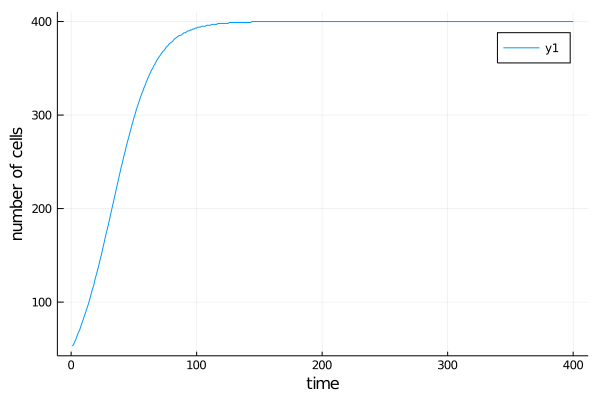

In [6]:
p2 = plot(map(length, cells_T_ID))
xlabel!("time")
ylabel!("number of cells")
display(p2)

In [7]:
# msd_t = BParts.meanSquaredDisplacement(pos_t_dim_id, arena.bounds);
# p = plot(msd_t)
# ylims!((0,20))
# xlabel!("time")
# ylabel!("msd")
# display(p)

In [8]:
using Distances
using Statistics

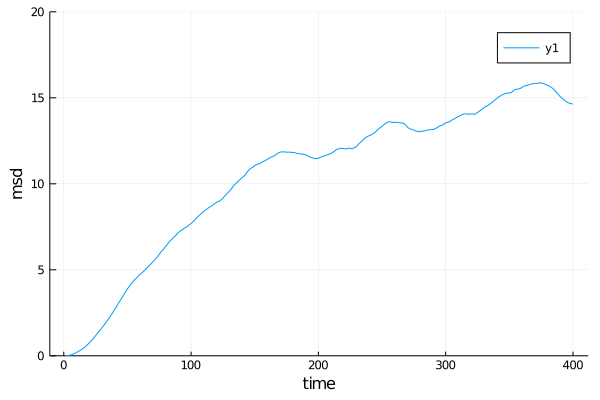

In [9]:
msd_t = BParts.meanSquaredDisplacement(pos_t_dim_id, arena.bounds);
p = plot(msd_t)
ylims!((0,20))
xlabel!("time")
ylabel!("msd")
display(p)


In [10]:
(sqrt(10^2+10^2)/4)^2

12.500000000000002

# Multiple simulations

In [11]:
nSims = 100

pos_Sim = Array{Array{Union{Float64, Missing},3}}(undef, nSims)
@showprogress for i in 1:nSims
    succes = false
    while !succes 
        # try/catch construction in case boundserror occurs
        try
            _, posSim_t_dim_id, __, ___ = 
                BParts.randArenaEvolve(arenaParams["n0"], arenaParams["evolveTime"], arenaParams, growthParams; 
                    progress=false, verbose=false);
            pos_Sim[i] = posSim_t_dim_id
        catch e
           continue 
        end
        succes = true
    end
end
    

Progress: 100%|█████████████████████████████████████████| Time: 0:02:34


In [12]:
msd_Sim = (p -> BParts.meanSquaredDisplacement(p, arena.bounds)).(pos_Sim);

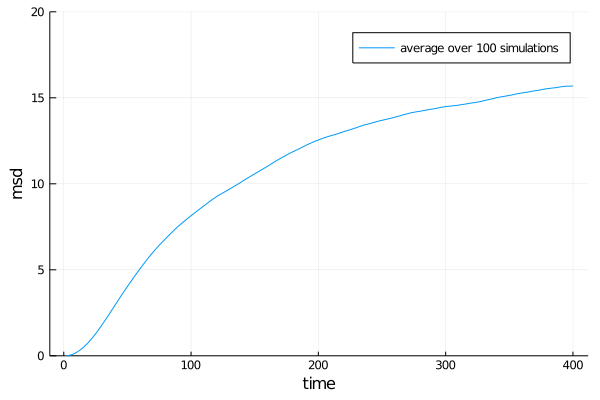

In [15]:
msdAv_t = Array{Float64, 1}(undef, arenaParams["evolveTime"])
for t in 1:arenaParams["evolveTime"]
    msdAv_t[t] = mean([ msd_tt[t] for msd_tt in msd_Sim ])
end
    
p1 = plot(msdAv_t, label="average over "*string(nSims)*" simulations")
ylims!((0,20))
xlabel!("time")
ylabel!("msd")
display(p1)
    